In [1]:
#  t! pip install ftfy regex tqdm

In [2]:
# ! pip install git+https://github.com/openai/CLIP.git

In [3]:
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
from PIL import Image

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import datasets, models, transforms
from torchsummary import summary
from typing import Callable, Dict, List, Tuple, Union
from torch.optim import lr_scheduler
# from torch.utils.tensorboard import SummaryWriter
# import skimage

import clip #importing clip model

print("Torch version:", torch.__version__)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.0.0+cu117


In [4]:
device = "cpu"
if torch.cuda.is_available:
  print('cuda available')
  device = torch.device("cuda:0")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

cuda available


In [5]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [6]:
# 왜 vit32 사용했는지

model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [7]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

In [8]:
print(input_resolution)
print(context_length)
print(vocab_size)

224
77
49408


In [9]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f827ac0a5e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Zero shot downstream task

## Test on EMNIST dataset

In [10]:
from torchvision.datasets import EMNIST

emnist = EMNIST(root=os.path.expanduser("~/.cache"), split="letters", transform=preprocess, download=False)


In [11]:
print(len(emnist))

124800


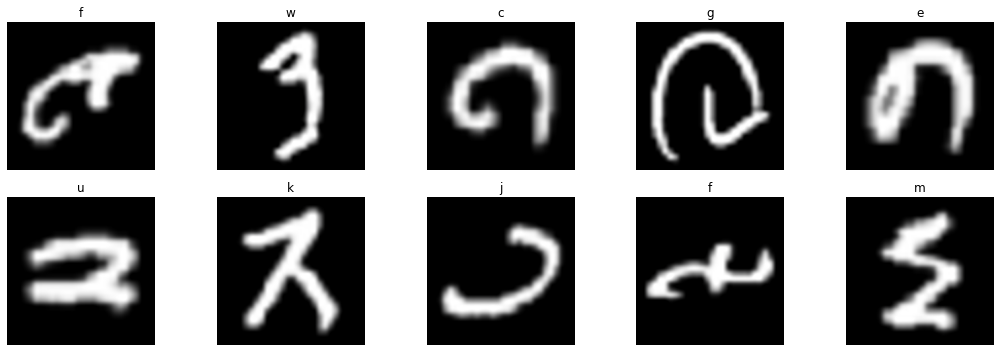

In [12]:
mean_mnist = [0.48145466, 0.4578275, 0.40821073]
std_mnist = [0.26862954, 0.26130258, 0.27577711]

class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

def show_grid(dataset: torchvision.datasets.ImageFolder, 
              process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.        
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))
    #indices_random= [x for x in range(8)]

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset.classes[dataset[idx][1]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(transforms.ToPILImage()(image_processed))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

denormalize = NormalizeInverse(mean_mnist, std_mnist)
show_grid(emnist, process=denormalize)

In [13]:
# train_set, val_set, test_set = torch.utils.data.random_split(cifar100, [40000, 8000,2000])

test_size = 5000
val_size = len(emnist) - test_size

val_set, test_set = torch.utils.data.random_split(emnist, [val_size,test_size])

print(emnist)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: /root/.cache
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               <function _convert_image_to_rgb at 0x7f827ac0a5e0>
               ToTensor()
               Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

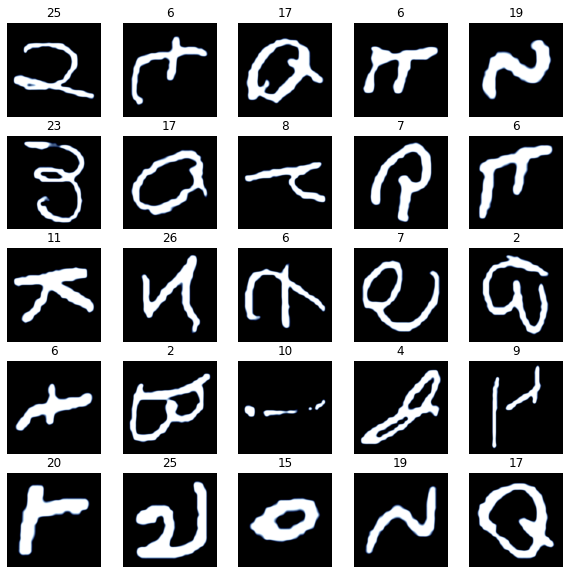

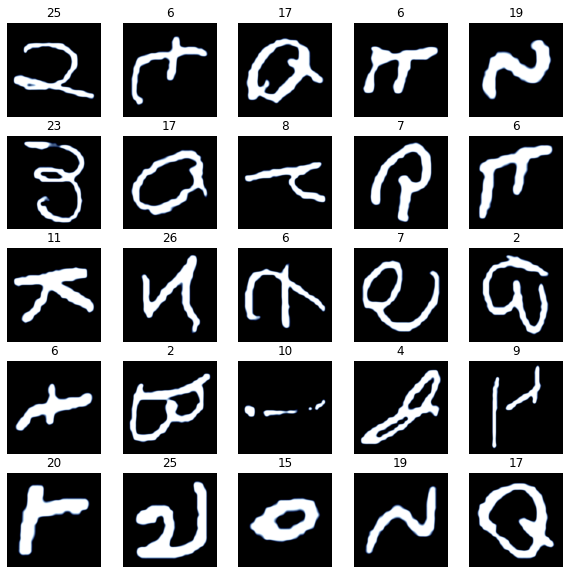

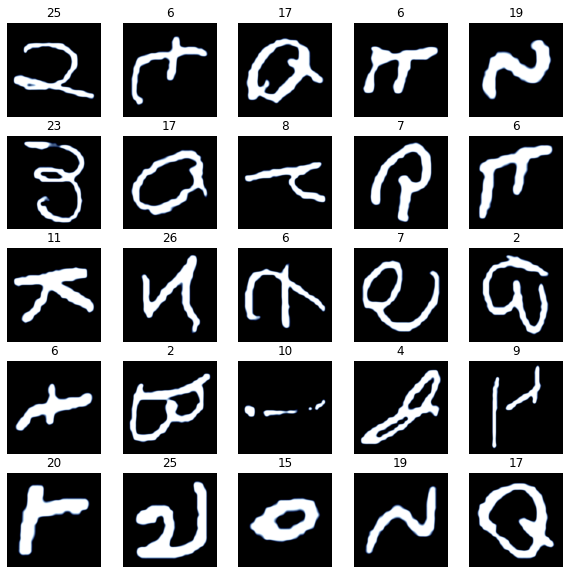

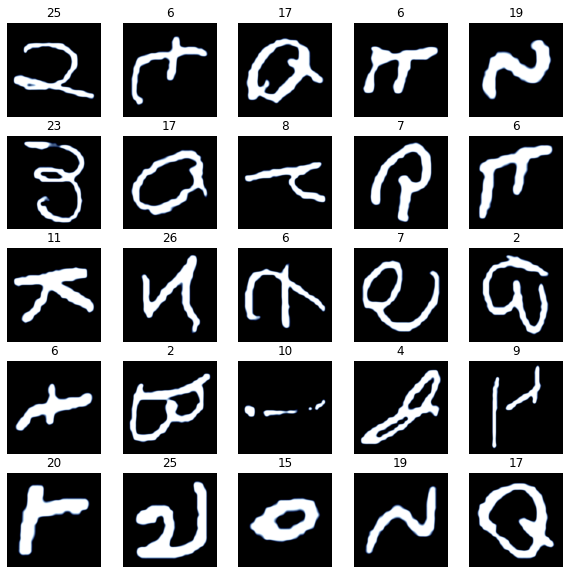

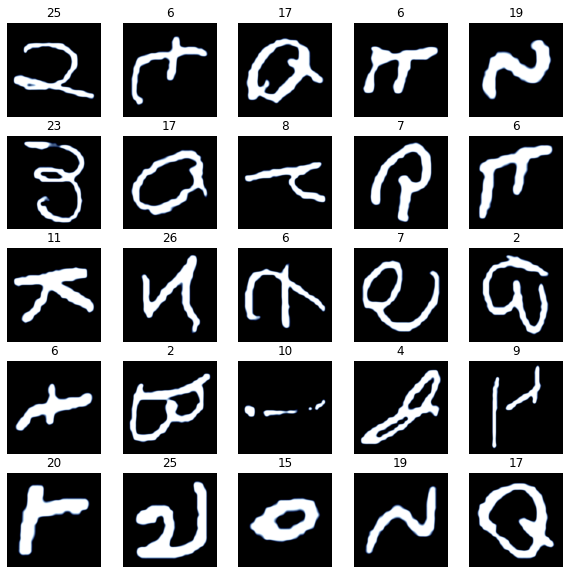

In [14]:
for i in range(5):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    for i in range(5):
        for j in range(5):
            img, label = test_set[i*5+j]
            img = np.transpose(img, (1, 2, 0))  # (3, 224, 224) -> (224, 224, 3)
            axes[i][j].imshow(img)
            axes[i][j].set_title(label)
            axes[i][j].axis("off")


## Batch 처리 : {label}

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import os
import clip

from torchvision.datasets import EMNIST

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

# 데이터셋 불러오기
emnist = EMNIST(root=os.path.expanduser("~/.cache"), split="letters", transform=preprocess, download=False)

# 데이터셋을 훈련 세트와 검증 세트로 분할
val_set, test_set = torch.utils.data.random_split(emnist, [0, 124800])

# 데이터 로더 정의
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


# 모델 및 텍스트 토큰화 함수 정의
text_tokens = clip.tokenize(emnist.classes).to(device)

# 모델 추론 및 정확도 계산
correct_labels = 0
total_labels = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 이미지 특성 추출
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # 텍스트 특성 추출
        text_features = model.encode_text(text_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # 텍스트 특성과의 유사도 계산
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.topk(5, dim=-1)

        # 정확도 계산
        correct_labels += (top_labels[:, 0] == labels).sum().item()
        total_labels += labels.size(0)

# 정확도 출력
accuracy = correct_labels / total_labels
print("The overall accuracy for the CLIP Zero-shot model without ensembling is: {}".format(accuracy))
print("Number of correct labels:", correct_labels)


The overall accuracy for the CLIP Zero-shot model without ensembling is: 0.06725961538461539
Number of correct labels: 8394


## Batch 처리 : a photo of a {label}

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import os
import clip

from torchvision.datasets import EMNIST

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

# 데이터셋 불러오기
emnist = EMNIST(root=os.path.expanduser("~/.cache"), split="letters", transform=preprocess, download=False)

# 데이터셋을 훈련 세트와 검증 세트로 분할
val_set, test_set = torch.utils.data.random_split(emnist, [0, 124800])

# 데이터 로더 정의
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


# 모델 및 텍스트 토큰화 함수 정의
text_descriptions = [f"a photo of a {label}" for label in emnist.classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

# 모델 추론 및 정확도 계산
correct_labels = 0
total_labels = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 이미지 특성 추출
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # 텍스트 특성 추출
        text_features = model.encode_text(text_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # 텍스트 특성과의 유사도 계산
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.topk(5, dim=-1)

        # 정확도 계산
        correct_labels += (top_labels[:, 0] == labels).sum().item()
        total_labels += labels.size(0)

# 정확도 출력
accuracy = correct_labels / total_labels
print("The overall accuracy for the CLIP Zero-shot model with ensembling is: {}".format(accuracy))
print("Number of correct labels:", correct_labels)


The overall accuracy for the CLIP Zero-shot model with ensembling is: 0.08862980769230769
Number of correct labels: 11061


## Batch 처리 : gpt prompt

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import os
import clip

from torchvision.datasets import EMNIST

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

# 데이터셋 불러오기
emnist = EMNIST(root=os.path.expanduser("~/.cache"), split="letters", transform=preprocess, download=False)

# 데이터셋을 훈련 세트와 검증 세트로 분할
val_set, test_set = torch.utils.data.random_split(emnist, [0, 124800])

# 데이터 로더 정의
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


# 모델 및 텍스트 토큰화 함수 정의
text_descriptions = [
    "This option represents an undefined character.",
    "This option represents the lowercase letter 'a'. It is written in a curved shape, starting with a downward stroke and followed by a curve.",
    "This option represents the lowercase letter 'b'. It has a curved shape with a small loop at the top.",
    "This option represents the lowercase letter 'c'. It is a curved letter with no loops or additional strokes.",
    "This option represents the lowercase letter 'd'. It has a rounded shape with a small loop at the top, similar to 'b' but with a straight vertical line.",
    "This option represents the lowercase letter 'e'. It is written with a curved shape, similar to 'c', but with a horizontal line in the middle.",
    "This option represents the lowercase letter 'f'. It has a straight vertical line and a small horizontal line at the top, similar to 't' without the downward stroke.",
    "This option represents the lowercase letter 'g'. It is written with a curved shape, starting with a downward stroke, followed by a loop at the bottom.",
    "This option represents the lowercase letter 'h'. It has a vertical line with a small horizontal line at the top-right corner, forming a hook-like shape.",
    "This option represents the lowercase letter 'i'. It is a simple straight vertical line, often written with a dot above it.",
    "This option represents the lowercase letter 'j'. It has a curved shape with a small hook at the top, similar to 'i' but with a longer tail.",
    "This option represents the lowercase letter 'k'. It has an angular shape, starting with a slanted stroke, followed by a vertical line, and ending with a loop at the bottom.",
    "This option represents the lowercase letter 'l'. It is a straight vertical line with no additional strokes.",
    "This option represents the lowercase letter 'm'. It has a series of three downward strokes, resembling two mountains connected by a valley.",
    "This option represents the lowercase letter 'n'. It is written with a slanted stroke followed by a straight vertical line.",
    "This option represents the lowercase letter 'o'. It is a circular shape with no additional strokes or loops.",
    "This option represents the lowercase letter 'p'. It has a rounded shape with a small loop at the top, similar to 'b' and 'd'.",
    "This option represents the lowercase letter 'q'. It is written with a rounded shape, starting with a downward stroke, followed by a loop at the bottom.",
    "This option represents the lowercase letter 'r'. It has a slanted stroke followed by a small loop at the top-right corner, similar to 'h' without the vertical line.",
    "This option represents the lowercase letter 's'. It is a curved letter with no additional strokes or loops.",
    "This option represents the lowercase letter 't'. It has a straight vertical line with a small horizontal line at the top, similar to 'f' but without the downward stroke.",
    "This option represents the lowercase letter 'u'. It is a curved letter with a small hook at the bottom.",
    "This option represents the lowercase letter 'v'. It has a V-shaped form with two diagonal strokes meeting at the bottom.",
    "This option represents the lowercase letter 'w'. It is written with two downward strokes connected by a central peak, resembling two mountains connected by a higher valley.",
    "This option represents the lowercase letter 'x'. It has a cross-like shape, with two diagonal strokes intersecting each other.",
    "This option represents the lowercase letter 'y'. It has a slanted shape, with a downward stroke and a shorter diagonal stroke connected at the bottom.",
    "This option represents the lowercase letter 'z'. It has a diagonal stroke starting from the top-left corner and ending at the bottom-right corner."

]
text_tokens = clip.tokenize(text_descriptions).to(device)

# 모델 추론 및 정확도 계산ㅠ
correct_labels = 0
total_labels = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 이미지 특성 추출
        image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # 텍스트 특성 추출
        text_features = model.encode_text(text_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # 텍스트 특성과의 유사도 계산
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        top_probs, top_labels = text_probs.topk(5, dim=-1)

        # 정확도 계산
        correct_labels += (top_labels[:, 0] == labels).sum().item()
        total_labels += labels.size(0)

# 정확도 출력
accuracy = correct_labels / total_labels
print("The overall accuracy for the CLIP Zero-shot model with gpt prompt engineering is: {}".format(accuracy))
print("Number of correct labels:", correct_labels)


The overall accuracy for the CLIP Zero-shot model with gpt prompt engineering is: 0.12875
Number of correct labels: 16068
